In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np

import jax.numpy as jnp
from jax import random, jit, value_and_grad, lax, partial, nn, vmap
from jax.experimental import optimizers

from util import progress_bar_scan, wait_until_computed, init_params

# NN classification

# 1. model and optimiser

In [2]:
# model
def predict(params, x):
    
    activation = x
    
    for W,b in params[:-1]:
        # note: nn.relu leads to much faster training than nn.softmax
        activation = nn.relu(jnp.dot(W,activation) + b)
        
    W_last, b_last = params[-1]
    return nn.log_softmax(jnp.dot(W_last, activation) + b_last)

batch_predict = vmap(predict, in_axes=(None, 0))

def loss_NN(params, x_data, y_data):
    return -jnp.mean(jnp.sum(batch_predict(params, x_data)*y_data, axis=1))

@jit
def accuracy(params, X, y):
    target_class = jnp.argmax(y, axis=1)
    predicted_class = jnp.argmax(batch_predict(params, X), axis=1)
    return jnp.mean(predicted_class == target_class)


# optimiser
@partial(jit, static_argnums=(0,))
def run_adam(Niters, l_rate, x_data, y_data, params_IC):
    
    opt_init, opt_update, get_params = optimizers.adam(l_rate)
    
    @progress_bar_scan(Niters)
    def body(state, step):
        loss_val, loss_grad = value_and_grad(loss_NN)(get_params(state), x_data, y_data)
        state = opt_update(step, loss_grad, state)
        return state, loss_val
    
    opt_state, loss_array = lax.scan(body, opt_init(params_IC), jnp.arange(Niters))
    return get_params(opt_state), loss_array

# toy dataset

In [3]:
key = random.PRNGKey(0)

Ndata = 15

x_data = random.uniform(key, shape=(Ndata, 2))
y_data = nn.one_hot(jnp.array([0,0,1,0,1,0,1,0,1,1,0,1,0,0,0]), 2)

# plt.title("data", size=20)
# sns.scatterplot(x_data[:,0], x_data[:,1], hue=jnp.argmax(y_data, axis=1), s=60)

In [4]:
key = random.PRNGKey(0)
M, D, K, L = 5,2,2, 2

# params = init_params_2layers(key, M, D, K)
params = init_params(key, M, D, K, L)

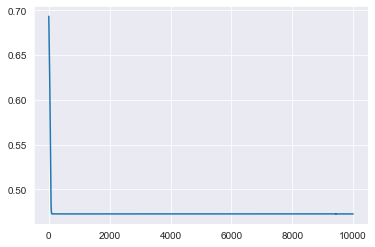

In [5]:
Niters = 10000
l_rate = 1e-2

opt_params, loss_array = run_adam(Niters, l_rate, x_data, y_data, params)

plt.plot(loss_array)

Text(0.5, 1.0, 'true data')

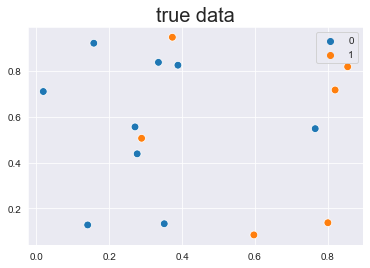

In [6]:
sns.scatterplot(x_data[:,0], x_data[:,1], hue=jnp.argmax(y_data, axis=1), s=60)
plt.title("true data", size=20)

Text(0.5, 1.0, 'predicted data')

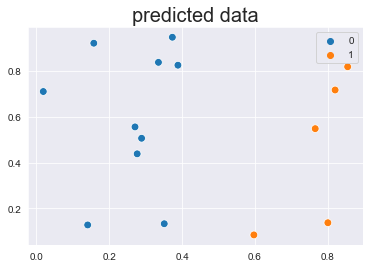

In [7]:
preds = jnp.argmax(batch_predict(opt_params, x_data,), axis=1)

sns.scatterplot(x_data[:,0], x_data[:,1], hue=preds, s=60)
plt.title("predicted data", size=20)

# MNIST

In [8]:
from MNIST_data import X_train, y_train, X_test, y_test

In [9]:

@partial(jit, static_argnums=(0,2))
def run_adam_sg(Niters, l_rate, batch_size, x_data, y_data, params_IC, X_test, y_test):
    
    Ndata = x_data.shape[0]
    opt_init, opt_update, get_params = optimizers.adam(l_rate)
    
    @progress_bar_scan(Niters)
    def body(state, step):
        key, opt_state = state
        key, subkey = random.split(key)
        idx_batch = random.choice(key=subkey, a=jnp.arange(Ndata), shape=(batch_size,))
        
        loss_val, loss_grad = value_and_grad(loss_NN)(get_params(opt_state), x_data[idx_batch,:], y_data[idx_batch,:])
        
        acc = accuracy(get_params(opt_state), X_test, y_test)
        opt_state = opt_update(step, loss_grad, opt_state)
        return (key, opt_state), (loss_val, acc)
    
    state = (key, opt_init(params_IC))
    (_, opt_state), (loss_array, accuracy_array) = lax.scan(body, state, jnp.arange(Niters))
    return get_params(opt_state), loss_array, accuracy_array

## 2 layers, 100 units

In [10]:
key = random.PRNGKey(0)
M, L = 100, 2
Ndata, D = X_train.shape
K = y_train.shape[1]

total_params = D*M + (M**2)*(L-2) + M*K + M + K

# params = init_params_2layers(key, M, D, K)
params = init_params(key, M, D, K, L)

print(f"Total number of parameters: {total_params}")

Total number of parameters: 79510


In [11]:
Niters = 5000
l_rate = 1e-2
batch_size = 1000

opt_params, loss_array, accuracy_array = run_adam_sg(Niters, l_rate, batch_size, X_train, y_train, params, X_test, y_test)

wait_until_computed(opt_params)

Final accuracy: 0.980


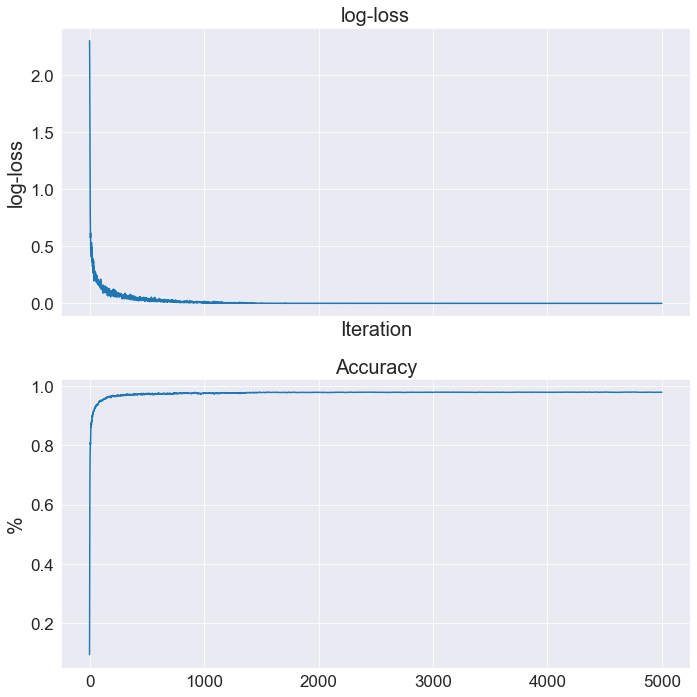

In [12]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(2, figsize=(10, 10), sharex=True)
ax[0].plot(loss_array)
ax[1].plot(accuracy_array)
ax[1].set_title("Accuracy", size=20)
ax[1].set_ylabel("%", size=20)
ax[0].set_title("log-loss", size=20)
ax[0].set_ylabel("log-loss", size=20)
ax[0].set_xlabel("Iteration", size=20)
plt.tight_layout()
print(f"Final accuracy: {accuracy_array[-1]:.3f}")